In [3]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Imputation libraries
import scprep # preprocessing
import saver
import magic
import scanpy as sc

from scipy.stats import spearmanr

# Clustering libraries
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import anndata

from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
#https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_04_clustering.html

/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 0: Load data with scanpy

In [4]:
path_data = "data/"
results_path = "results"
archive_name = "CarballoCastro_Alba.zip"

In [39]:
#Read the bulk and set gene names as variables and patients as observations

bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
bulk = sc.read(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).transpose()
bulk.var['gene_id'] = bulk_pancreas.index
bulk.obs ['patient_id'] = bulk_pancreas.columns
bulk.var_names_make_unique()

In [ ]:
#Now I read the single cell data and metadata
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")
sc_train = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).transpose()
sc_train.var['gene_id'] = sc_pancreas.index
sc_train.obs['cell_id'] = sc_pancreas.columns
sc_train.obs['cell_type']= sc_pancreas_metadata['Celltype']
sc_train.var_names_make_unique()

# I also read the single cell test data and metadata

sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

sc_test = sc.read(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).transpose()
sc_test.var['gene_id'] = sc_pancreas_test.index
sc_test.obs['cell_id'] = sc_pancreas_test.columns
sc_test.var_names_make_unique()

In [57]:
print(f"Number of patients in the train dataset {bulk.X.shape[0]}")

print(f"Number of genes in the dataset {bulk.X.shape[1]}")

assert bulk.X.shape[1] == sc_train.X.shape[1]
print(f"Number of cells in the train dataset {sc_train.X.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453
Number of cells in the train dataset 978


In [58]:
print(f"Number of cells in the test dataset {sc_test.X.shape[0]}")

Number of cells in the test dataset 789


In [59]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [60]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [61]:
print(f"There are {sc_pancreas_metadata.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {sc_pancreas_metadata.Celltype.unique()}")

There are 13 different cell types in the dataset
The different cells types are ['acinar cell' 'alpha cell' 'gamma cell' 'delta cell'
 'unclassified endocrine cell' 'beta cell' 'ductal cell'
 'endothelial cell' 'co-expression cell' 'PSC cell' 'epsilon cell'
 'MHC class II cell' 'mast cell']


In [62]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [63]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


# Step 1: Data preprocessing

In [65]:
# For the imputation, we need to have the data log transformed
sc.pp.log1p(bulk)
sc.pp.log1p(sc_train)
sc.pp.log1p(sc_test)

#TODO: check why I get the warning

# Step 2: Perform the imputation

### Data preprocessing

* Filtering: we see that data is prefiltered
* Removing unexpressed genes? -> MAGIC recomienda pero según las guidelines no se debe eliminar ningún gen

<Axes: xlabel='Library size', ylabel='Number of cells'>

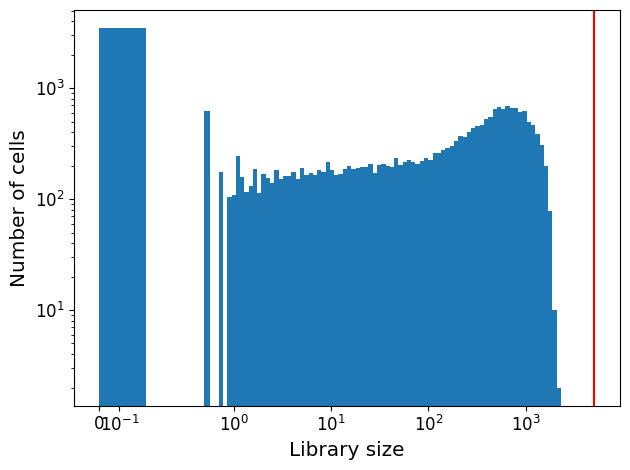

In [69]:
scprep.plot.plot_library_size(sc_train.X.transpose(), cutoff=5000)

### Imputation using MAGIC

In [70]:
magic_op = magic.MAGIC()

In [71]:
#Apply MAGIC in the whole training data
sc_magic = magic_op.fit_transform(sc_train.X)

Calculating MAGIC...
  Running MAGIC on 978 cells and 25453 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 3.75 seconds.
  Running MAGIC with `solver='exact'` on 25453-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.51 seconds.
Calculated MAGIC in 4.29 seconds.


In [77]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene

assert sc_pancreas_metadata.shape[0] == sc_magic.shape[0]


[[0.01186054 0.02520915 1.06716606 ... 0.         0.         0.        ]
 [0.03815708 0.2929993  0.18101215 ... 0.         0.         0.        ]
 [0.28258287 0.26680337 0.26265101 ... 0.         0.         0.        ]
 ...
 [0.1469917  0.3746123  0.42987069 ... 0.         0.         0.        ]
 [0.20049023 0.46224341 0.54441609 ... 0.         0.         0.        ]
 [0.10639384 0.17783898 0.1673622  ... 0.         0.         0.        ]]
(978, 25453)


In [98]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene

assert sc_pancreas_metadata.shape[0] == sc_magic.shape[0]
df_magic = pd.DataFrame(sc_magic, index= sc_pancreas_metadata.index, columns= sc_train.var['gene_id'])
train_merged = sc_pancreas_metadata.join(df_magic, on='Source Name')
train_bulkified = train_merged.groupby('Sample', as_index= False).mean()
train_bulkified.drop(train_bulkified.columns[0],axis=1, inplace=True)
train_bulkified.index = ["patient1","patient2","patient3","patient4"]
print(f'Train bulkified matrix shape is : {train_bulkified.shape}')
print(f'Train bulk matrix shape is : {bulk.X.shape}')

#I will transpose them so that they agree with the previous dimensions just in case
train_bulkified_t = train_bulkified.transpose()
bulk_t = bulk.transpose()

print(f'Transposed train bulkified matrix shape is : {train_bulkified_t.shape}')
print(f'Transposed train bulk matrix shape is : {bulk_t.X.shape}')

Train bulkified matrix shape is : (4, 25453)
Train bulk matrix shape is : (4, 25453)
Transposed train bulkified matrix shape is : (25453, 4)
Transposed train bulk matrix shape is : (25453, 4)


### Performance evaluation: Spearman

In [99]:
# MAGIC
corr, pval = spearmanr(bulk_t.X, train_bulkified_t)
spearman = corr.mean()
print(f'Spearman correlation for train is {spearman}')

Spearman correlation for train is 0.9572405652130017


In [32]:
#TODO: train magic with all the train data, predict on test and provide the file in the final format


# Step 3: Perform clustering 

## Trial of clustering on imputed data 

In [352]:
#Whole code
sc_imput = sc.read(os.path.join(path_data,"magic_imputation.csv"), cache=True)
sc.settings.verbosity = 3 
sc_imput.var['gene_id'] = sc_pancreas.index
sc_imput.obs['cell_id'] = sc_pancreas.columns
sc_imput.obs['cell_type']= sc_pancreas_metadata['Celltype']
sc_imput.obs['batch']= sc_pancreas_metadata['Sample']
sc_imput.var_names_make_unique()

#Preprocesing
#sc.pp.filter_cells(sc_imput, min_genes=200)
#sc.pp.filter_genes(sc_imput, min_cells=10)

sc.pp.normalize_total(sc_imput, target_sum=1e4)
sc_imput.raw = sc_imput
sc.pp.highly_variable_genes(sc_imput, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_imput = sc_imput[:, sc_imput.var.highly_variable]
sc.pp.scale(sc_imput, max_value=10)

#We can tune n_comps
sc.tl.pca(sc_imput, n_comps = 20)

#We can tune graph params
sc.pp.neighbors(sc_imput, n_neighbors=7, n_pcs=20)

#We can tune this
sc.tl.leiden(sc_imput, resolution = 0.27)


... reading from cache file cache/data-magic_imputation.h5ad
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=20


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


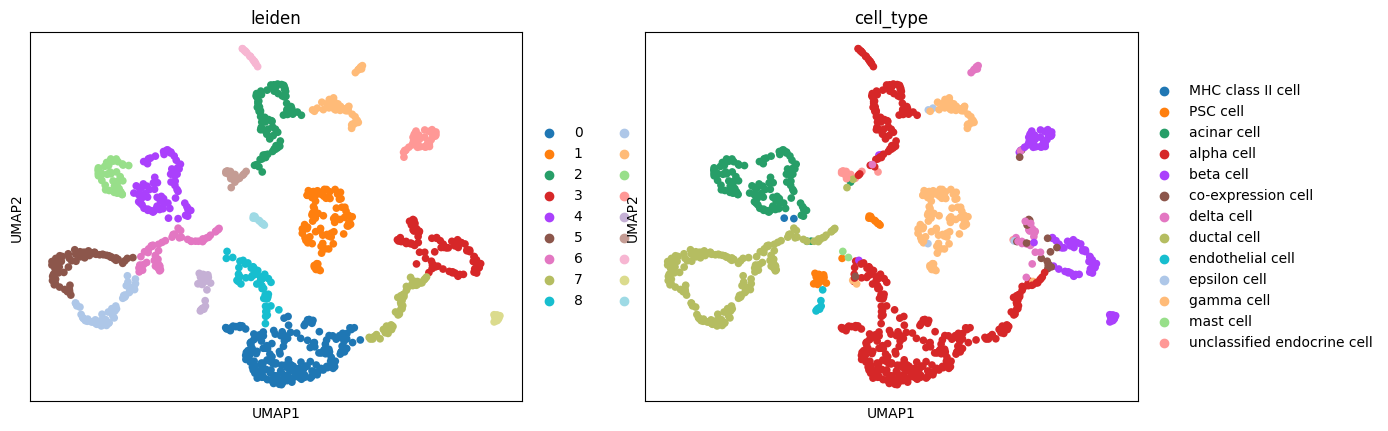

In [354]:
sc.tl.umap(sc_imput)
sc.pl.umap(sc_imput, color=['leiden', 'cell_type'])

In [355]:
#Obtain labels from leiden clustering
leiden_labels = sc_imput.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value

#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_imput, n_comps= 50)
pca_matrix_50 = sc_imput.obsm['X_pca']

#Encode the true labels

cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)

ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
Silhouette score: 0.37023768
Adjusted Rand Index: 0.4490429719917874
V-Measure score: 0.7024494770934391
Performance: 0.5072433757915467


In [ ]:
#TODO: try on non imputed data also

# Code by parts

In [ ]:
df_magic.to_csv(os.path.join(path_data,"magic_imputation.csv"))

In [340]:
sc_imput = sc.read(os.path.join(path_data,"magic_imputation.csv"), cache=True)
sc.settings.verbosity = 3 

... reading from cache file cache/data-magic_imputation.h5ad


In [341]:
sc_imput.var['gene_id'] = sc_pancreas.index
sc_imput.obs['cell_id'] = sc_pancreas.columns
sc_imput.obs['cell_type']= sc_pancreas_metadata['Celltype']
sc_imput.obs['batch']= sc_pancreas_metadata['Sample']

In [342]:
sc_imput.var_names_make_unique()

### Preprocessing

In [343]:
sum_per_row = sc_imput.X.sum(axis=1)
sum_per_row.sort()

In [344]:
sc.pp.filter_cells(sc_imput, min_genes=200)
sc.pp.filter_genes(sc_imput, min_cells=10)

filtered out 3489 genes that are detected in less than 10 cells


In [345]:
#The data is already log1p transformed
#I will normalize the data in counts per cell
sc.pp.normalize_total(sc_imput, target_sum=1e4)
sc_imput.raw = sc_imput
sc.pp.highly_variable_genes(sc_imput, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc_imput = sc_imput[:, sc_imput.var.highly_variable]
sc.pp.scale(sc_imput, max_value=10)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [346]:
#sc.pp.combat(sc_imput) worse results 

### PCA dimensionality reduction

In [347]:
sc.tl.pca(sc_imput, n_comps = 50 )

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


### Graph constructing for clustering

In [348]:
sc.pp.neighbors(sc_imput, n_neighbors=20, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


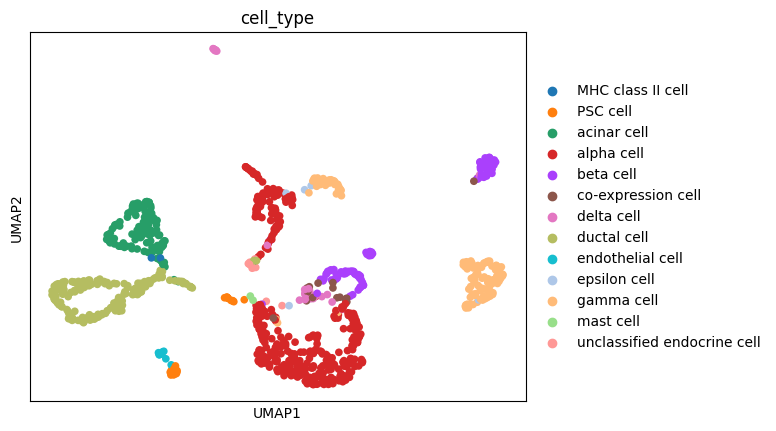

In [349]:
sc.tl.umap(sc_imput)
sc.pl.umap(sc_imput, color=['cell_type'])

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


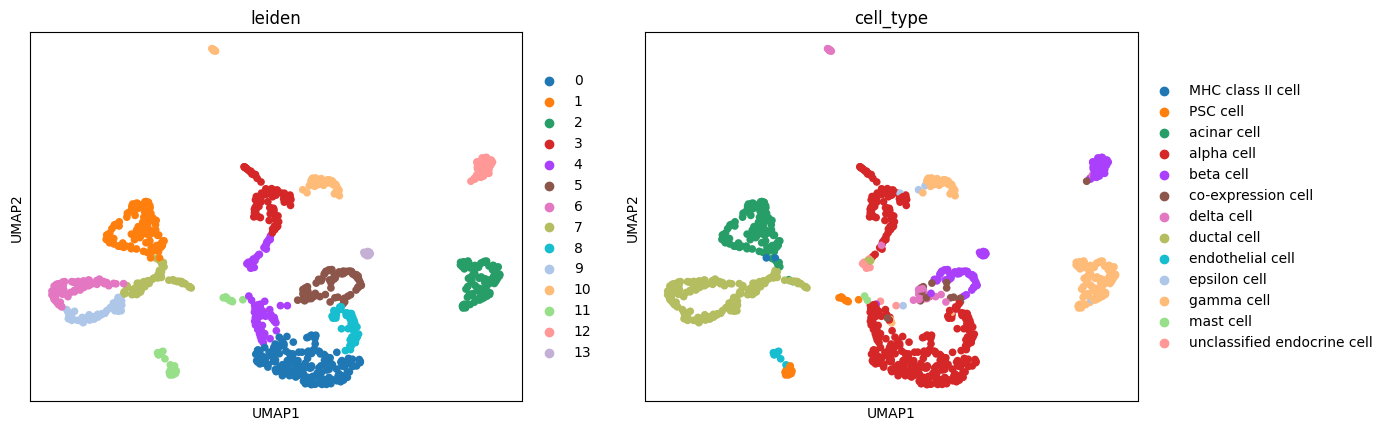

In [350]:
sc.tl.leiden(sc_imput, resolution = 0.27)
sc.pl.umap(sc_imput, color=['leiden', 'cell_type'])


In [336]:
#Obtain labels from leiden clustering
leiden_labels = sc_imput.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value

In [337]:
#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_imput, n_comps= 50)
pca_matrix_50 = sc_imput.obsm['X_pca']

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [338]:
#Encode the true labels

cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)
#decoded_label = encoder.inverse_transform(encoded_label)

In [339]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.3170692
Adjusted Rand Index: 0.43209160044545414
V-Measure score: 0.6846848004973645
Performance: 0.47794853453477765


In [145]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.4131441
Adjusted Rand Index: 0.5105278510946296
V-Measure score: 0.7257708595284396
Performance: 0.5498142740854566


### PCA Dataframe

In [49]:
PCA_df = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
print(PCA_df.shape)
PCA_df.insert(loc=0, column='index', value=sc_pancreas_shuff.columns)
print(PCA_df)

(978, 50)
            index        PC1        PC2        PC3        PC4       PC5  \
0    patient1_A10  39.490681 -20.499043  10.986668  10.927416 -3.109414   
1    patient1_A12   4.717423  20.595693  -0.277624  -0.439507 -7.033983   
2    patient1_A13   0.291647  16.357360   1.592786  -3.183454  7.022762   
3    patient1_A15  -2.321775  15.283787   1.380685  -3.231049  6.960572   
4    patient1_A17  -4.652297  13.740515   2.381843  -4.307614  6.516131   
..            ...        ...        ...        ...        ...       ...   
973   patient4_P5 -39.715698  -9.969509   6.758491 -10.204981  1.756090   
974   patient4_P6 -22.410125   1.621995   5.225262  -8.089692 -1.295003   
975   patient4_P7  27.927174  26.581637   1.586859  -1.414822 -1.906928   
976   patient4_P8  44.413107  27.502105   2.433108  -1.317397 -0.623382   
977   patient4_P9 -30.345743  -2.639151   5.941460  -9.337001 -0.719281   

          PC6        PC7       PC8       PC9  ...      PC41      PC42  \
0   -1.577474   

### Scanpy tutorial for clustering on NOT imputed data

In [54]:
sc.pp.log1p(sc_pancreas_t)
sc_pancreas_t.raw = sc_pancreas_t

In [55]:
sc.tl.pca(sc_pancreas_t, n_comps= 20)

In [56]:
sc.pp.neighbors(sc_pancreas_t, n_neighbors=10, n_pcs=20)

In [57]:
sc.tl.umap(sc_pancreas_t)

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


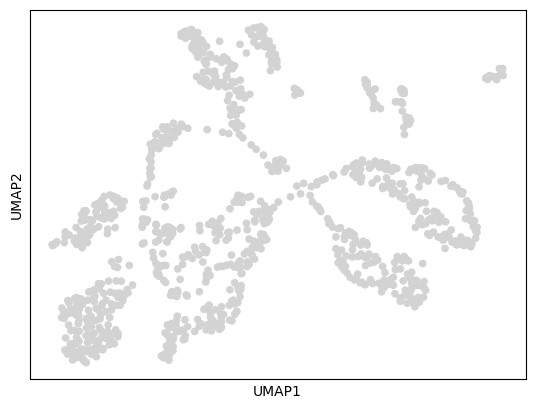

In [58]:
sc.pl.umap(sc_pancreas_t,use_raw=True)

In [59]:
sc.tl.leiden(sc_pancreas_t, resolution =0.40005)

/home/acarballocastro/.conda/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


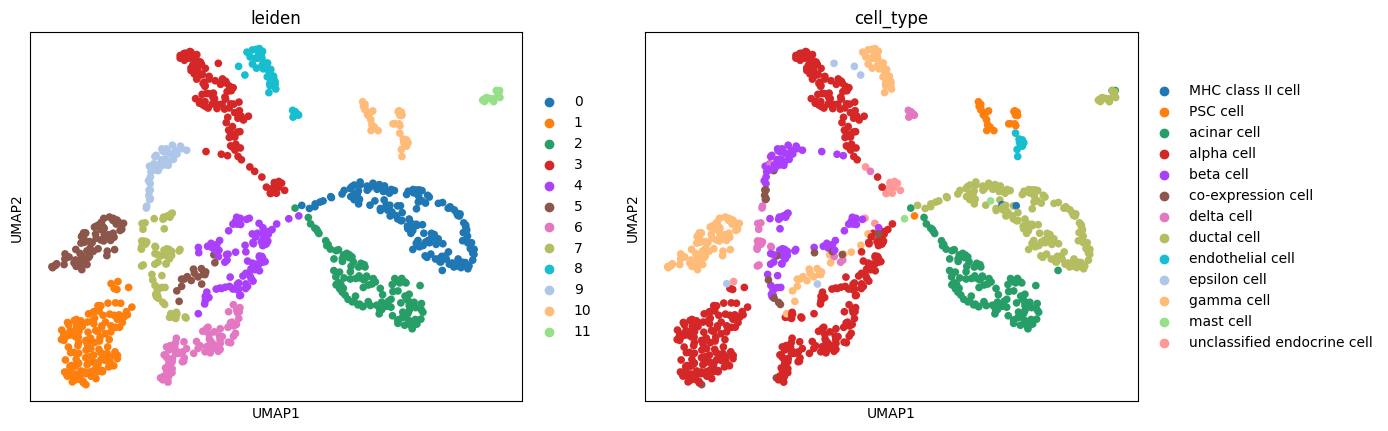

In [60]:
sc.pl.umap(sc_pancreas_t, color=['leiden', 'cell_type'])

In [61]:
#Obtain labels from leiden clustering
leiden_labels = sc_pancreas_t.obs['leiden']
leiden_l = np.empty((978,), dtype=int)
for i in range(978):
    value= leiden_labels[i]
    leiden_l[i]= value


In [62]:
#Compute PCA space to evaluate silhuoette coefficie
sc.tl.pca(sc_pancreas_t, n_comps= 50)
pca_matrix_50 = sc_pancreas_t.obsm['X_pca']
#El resultado es

In [63]:
ssc = silhouette_score(pca_matrix_50, leiden_l)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(encoded_label, leiden_l)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(encoded_label, leiden_l)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.09669445
Adjusted Rand Index: 0.47654318626591646
V-Measure score: 0.6920866225624616
Performance: 0.42177475197618014


# Step 3: Predict on the test data

Cuando decidamos qué tecnicas de imputación y clustering son mejores, hacerlo en los datos de test.

# Step 4: Save the required files

In [ ]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [ ]:
# assert all(bulkified.columns == ["index","patient5","patient6","patient7"])
# assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(cluster_labels.columns == ["index","cluster"])
# assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])
# assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
# with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
#     with zf.open(f"imputed_bulkified.csv", "w") as buffer:
#         bulkified.to_csv(buffer)
#     with zf.open(f"cluster_membership.csv", "w") as buffer:
#         cluster_labels.to_csv(buffer)
#     with zf.open(f"PCA.csv", "w") as buffer:
#         PCA.to_csv(buffer)
#     zf.close()

In [ ]:
# archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
# assert all(
#         [
#             i in archive.namelist()
#             for i in [
#                 "imputed_bulkified.csv",
#                 "cluster_membership.csv",
#                 "PCA.csv",
#             ]
#         ]
#     )